In [2]:
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install pyproj==1.9.6 --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [3]:
import re
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

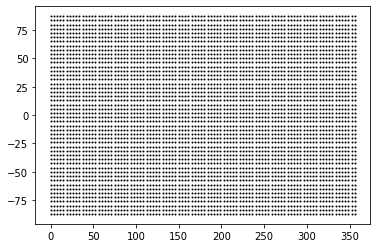

In [4]:
X_speedy_lon = np.linspace(0,360-3.75,96)
Y_speedy_lat = np.array("-87.159 -83.479 -79.777 -76.070 -72.362 -68.652 -64.942 -61.232 -57.521 -53.810 -50.099 -46.389 -42.678 -38.967 -35.256 -31.545 -27.833 -24.122 -20.411 -16.700 -12.989 -9.278 -5.567 -1.856 1.856 5.567 9.278 12.989 16.700 20.411 24.122 27.833 31.545 35.256 38.967 42.678 46.389 50.099 53.810 57.521 61.232 64.942 68.652 72.362 76.070 79.777 83.479 87.159".split(" "))
Y_speedy_lat = Y_speedy_lat.astype(np.float32)

def plot_speedy():
    plt.figure()
    for x in X_speedy_lon:
        for y in Y_speedy_lat:
            plt.plot(x,y,'ko',ms=1);

plot_speedy()

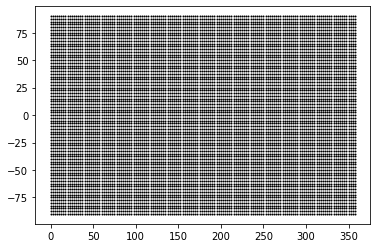

In [5]:
## NOAA latitude goes from North To South
X_noaa_lon = np.linspace(0,360-2.5,144)
Y_noaa_lat = np.linspace(90,-90,73)

def plot_noaa():
    plt.figure()
    for x in X_noaa_lon:
        for y in Y_noaa_lat:
            plt.plot(x,y,'ko',ms=1);

plot_noaa()

In [6]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(['script', 'style']):
            script.extract()
        return soup
    except Exception:
        return None


def get_stations_noaa():
    soup = fetch('https://tgftp.nws.noaa.gov/data/observations/metar/stations/')
    stations = []
    for link in soup.find_all('a'):
        href = link.get('href')
        if 'TXT' in href:
            stations.append(href.split('.TXT')[0])
    return stations


def get_stations_with_coords():
    soup = fetch('http://weather.rap.ucar.edu/surface/stations.txt')
    text = soup.get_text()
    matches = re.findall(r".*([A-Z]{4}).*([\d]{2}\s[\d]{2}\w).*([\d]{2}\s[\d]{2}\w)[\s]*(\d{1,4}).*", text)
    stations = []
    for match in matches:
        stations.append({'ICAO': match[0],
                        'coords': '+'.join(match[1:]).replace(' ', '-'
                        )})
    return stations


In [147]:
df = pd.read_csv('8-9_metar.csv')
df.head()

,coordinates,observation
0,56-56N+54-11W+14,PAKH 101856Z AUTO RMK AO2 SLPNO PWINO FZRANO $
1,54-09N+65-36W+25,PAUT 051615Z AUTO 05013KT A2991 RMK AO2 PWINO
2,54-09N+65-36W+25,PAUT 301055Z AUTO 10SM OVC020 09/05 A2939 RMK ...
3,54-09N+65-36W+25,PAUT 301115Z AUTO 10SM OVC023 09/05 A2938 RMK ...
4,71-17N+56-48W+7,PABR 191802Z 04012KT 4SM -SN BR OVC009 02/M01 ...


In [148]:
len(df)

2690611

In [8]:
noaa_stations = get_stations_with_coords()

In [149]:
def gms_to_lat_lng(gms):
    comp = gms.split('-')
    if len(comp) == 2:
        if 'N' in comp[1] or 'E' in comp[1]:
            return int(comp[0]) + int((comp[1])[:len(comp)]) / 60
        else:
            return -(int(comp[0]) + int((comp[1])[:len(comp)]) / 60)
    elif len(comp) == 3:
        if 'N' in comp[2] or 'E' in comp[2]:
            return int(comp[0]) + int((comp[1])[:len(comp)]) / 60 + int((comp[2])[:len(comp) - 1]) / 60
        else:
            comp[2] = '0' + (comp[2])[:len(comp) - 1]
            return -int(comp[0]) - int((comp[1])[:len(comp)]) / 60 - int((comp[2])[:len(comp) - 1]) / 3600
    else:
        return 0

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)


In [150]:
PRESSURE_LEVELS_VALUES = [
    925,
    850,
    700,
    500,
    300,
    200,
    100,
]

def wind_comps(obs):
    # ESE at 11 knots
    # WSW at greater than 99 knots
    if 'knots' in obs and 'variable' not in obs:
        compass_point, mag = re.findall(r".*wind:\s(\w+).*([0-9]+)[\s]knots", obs)[0]
        ang = portolan.middle(compass_point)
        mag = int(mag) / 1.944
        u = mag * np.sin(ang)
        v = mag * np.cos(ang)
        return (u, v)
    else:
        return (0, 0)


def month2number(month_name):
    datetime_object = datetime.datetime.strptime(month_name, '%b')
    return datetime_object.month


def parse_datetime(time):
    return datetime.datetime.strptime(time, '%a %b %d %H:%M:%S %Y')


def elev_to_press_level(elev):
    max_diff = 10000
    level = 0
    for (idx, val) in enumerate(PRESSURE_LEVELS_VALUES):
        diff = abs(val - elev)
        if max_diff > diff:
            level = idx
            max_diff = diff
    return level


def calculate_rh(dew_point, temp):
    c = 243.04
    b = 17.625
    return 100 * np.exp(c * b * (dew_point - temp) / ((c + temp) * (c + dew_point)))

def parse_pressure(obs):
    # pressure: 1027.8 mb
    # 3-hr pressure change 1.7hPa, increasing, then decreasing
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0]) * 100
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0]) * 100
    return press


In [151]:
obs_cords = []
stations = []
data = []
errors = 0

idx = 1057228
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)

if 'wind' in obs and 'temperature' in obs and 'pressure' in obs \
    and 'time' in obs and 'station' in obs and 'dew point' in obs:
    dt = []
    (lat, lng, elev) = row['coordinates'].split('+')
    new_cord = (gms_to_lat_lng(lat), gms_to_lat_lng(lng), elev)

    station = re.findall(r".*station:\s(.*)\s*", obs)[0]

    # lat
    dt.append(new_cord[0])

    # lng
    dt.append(new_cord[1])

    # level
    dt.append(elev_to_press_level(int(elev)))

    time = re.findall(r".*time:\s(.*)\s*", obs)[0]
    obs_date = parse_datetime(time)

    # date
    dt.append(obs_date)

    temp = float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0])

    # temp
    dt.append(float(temp))

    dew_point = float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*",
                      obs)[0])

    # dew_point
    dt.append(float(dew_point))

    (u, v) = wind_comps(obs)
    # wind u comp
    dt.append(u)
    # wind v comp
    dt.append(v)

    # press
    press = parse_pressure(obs)
    dt.append(press)

    # rh
    rh = calculate_rh(dew_point, temp)
    dt.append(rh)

    if obs_date.hour == 0 or obs_date.hour == 6 or obs_date.hour == 12 \
        or obs_date.hour == 18:
        data.append(dt)
        if new_cord not in obs_cords:
            obs_cords.append(new_cord)
            stations.append(station)

    print(data)

station: ESMT
type: routine report, cycle 16 (automatic report)
time: Sat Oct  3 15:50:00 2020
temperature: 17.0 C
dew point: 11.0 C
wind: SSW at 6 knots
visibility: 10000 meters
pressure: 1014.0 mb
METAR: ESMT 031550Z 21006KT CAVOK 17/11 Q1014
[]


In [152]:
obs_cords = []
stations = []
data = []
errors = 0

for idx in tqdm(range(len(df))):
    try:
        row = df.iloc[idx]
        obs = Metar.Metar(row['observation']).string()
        if 'wind' in obs and 'temperature' in obs and 'pressure' in obs and 'time' in obs and 'station' in obs and 'dew point' in obs:
            dt = []
            (lat, lng, elev) = row['coordinates'].split('+')
            new_cord = (gms_to_lat_lng(lat), gms_to_lat_lng(lng), elev)

            station = re.findall(r".*station:\s(.*)\s*", obs)[0]

            #lat
            dt.append(new_cord[0])
            #lng
            dt.append(new_cord[1])

            #level
            dt.append(elev_to_press_level(int(elev)))

            time = re.findall(r".*time:\s(.*)\s*", obs)[0]
            obs_date = parse_datetime(time)
            #date
            dt.append(obs_date)

            temp = float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0])
            #temp
            dt.append(float(temp))

            dew_point = float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0])
            #dew_point
            dt.append(float(dew_point))

            (u, v) = wind_comps(obs)
            # wind u comp
            dt.append(u)
            # wind v comp
            dt.append(v)

            #pressure
            press = parse_pressure(obs)
            dt.append(press)

            #rh
            rh = calculate_rh(dew_point, temp)
            dt.append(rh)

            if obs_date.hour == 0 or obs_date.hour == 6 or obs_date.hour == 12 or obs_date.hour == 18:
                data.append(dt)
                if new_cord not in obs_cords:
                    obs_cords.append(new_cord)
                    stations.append(station)
    except Exception as e:
        errors += 1
        if 'Unparsed groups' not in str(e) and '_handleTime' not in str(e) and '_handleWind' not in str(e):
            print('index:', idx, 'error:', e)

print(f"errors {errors}")

index: 1973710 error: 'NSW'
index: 2111040 error: 'NSW'
index: 2111098 error: 'NSW'
index: 2111319 error: 'NSW'
index: 2111328 error: 'NSW'
index: 2111329 error: 'NSW'
index: 2111330 error: 'NSW'
index: 2111331 error: 'NSW'
index: 2111333 error: 'NSW'
index: 2111334 error: 'NSW'
index: 2111335 error: 'NSW'
index: 2111337 error: 'NSW'
index: 2111366 error: 'NSW'
index: 2111367 error: 'NSW'
index: 2426759 error: 'NSW'
index: 2426760 error: 'NSW'
index: 2426761 error: 'NSW'
index: 2426763 error: 'NSW'
index: 2426764 error: 'NSW'
index: 2426766 error: 'NSW'
index: 2426768 error: 'NSW'
index: 2426769 error: 'NSW'
index: 2426770 error: 'NSW'
index: 2426771 error: 'NSW'
index: 2426772 error: 'NSW'
index: 2426773 error: 'NSW'
index: 2426774 error: 'NSW'
index: 2426775 error: 'NSW'
index: 2493085 error: 'NSW'
index: 2493086 error: 'NSW'
index: 2493087 error: 'NSW'
index: 2493088 error: 'NSW'
index: 2493089 error: 'NSW'
index: 2493090 error: 'NSW'
index: 2493091 error: 'NSW'
index: 2493099 error

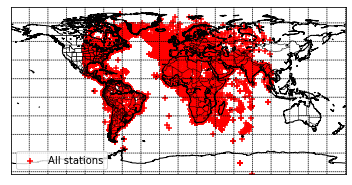

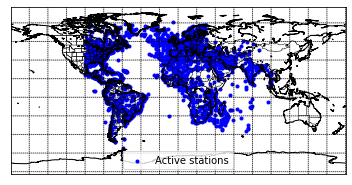

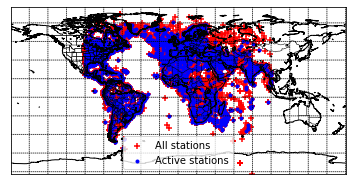

In [153]:
lati = []
lngt = []
lati2 = []
lngt2 = []
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    lati.append(gms_to_lat_lng(lat))
    lngt.append(gms_to_lat_lng(lng))
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
plt.legend()
plt.savefig('estaciones.jpg', dpi=600)
plt.show()

for stat in obs_cords:
    lati2.append(stat[0])
    lngt2.append(stat[1])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('estaciones2.jpg', dpi=600)
plt.show()

m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(
    lngt,
    lati,
    marker='+',
    color='r',
    zorder=1.5,
    label='All stations',
    )
m.scatter(
    lngt2,
    lati2,
    marker='.',
    color='b',
    zorder=1.5,
    label='Active stations',
    )
plt.legend()
plt.savefig('estaciones3.jpg', dpi=600)
plt.show()


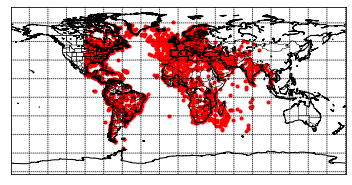

In [154]:
lati = []
lngt = []
for stat in obs_cords:
    lati.append(stat[0])
    lngt.append(stat[1])
m = Basemap(resolution='l', lat_0=0, lon_0=0)
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.drawparallels(np.arange(-87.159, 87.159, 20))
m.drawmeridians(np.arange(0, 357.5, 20))
m.fillcontinents(color='white')
m.scatter(lngt, lati, marker='.', color='r', zorder=1.5)
plt.savefig('estaciones.jpg', dpi=600)
plt.show()


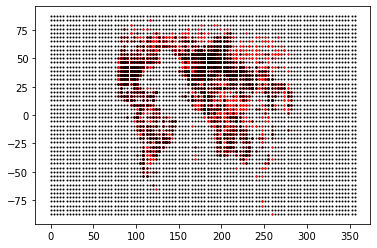

In [155]:
plot_speedy()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in tqdm(obs_cords):
    (x, y) = nearest_neighbour(X_speedy_lon, Y_speedy_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


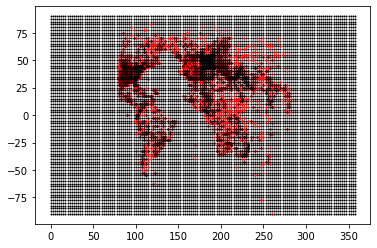

In [156]:
plot_noaa()
for station in noaa_stations:
    (lat, lng, elev) = station['coords'].split('+')
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat,
                               gms_to_lat_lng(lng) + 180,
                               gms_to_lat_lng(lat))
    plt.plot(x, y, 'ro', ms=1)

for cord in tqdm(obs_cords):
    (x, y) = nearest_neighbour(X_noaa_lon, Y_noaa_lat, cord[1]
                               + 180, cord[0])
    plt.plot(x, y, 'ko', ms=1)


In [157]:
obs_df = pd.DataFrame(data, columns=['lat','lng','level','datetime','temp','dew_point','u','v','pressure','rh'])
obs_df.head()

,lat,lng,level,datetime,temp,dew_point,u,v,pressure,rh
0,71.283333,-56.800000,6,2020-09-19 18:02:00,2.0,-1.0,0.875415,0.540455,100200.0,80.519354
1,68.883333,-66.133333,6,2020-10-01 00:55:00,5.0,3.0,3.501661,2.161819,100000.0,86.902676
2,68.883333,-66.133333,6,2020-10-01 12:55:00,4.0,2.0,-1.027800,-0.045502,100410.0,86.803363
3,68.883333,-66.133333,6,2020-10-01 18:55:00,4.0,2.0,0.437708,0.270227,100610.0,86.803363
4,68.883333,-66.133333,6,2020-10-02 00:55:00,4.0,3.0,0.875415,0.540455,100750.0,93.195122


In [158]:
obs_df.to_csv('Metars.csv', index=False)

In [159]:
obs_df = pd.read_csv('Metars.csv')
obs_df.head()

,lat,lng,level,datetime,temp,dew_point,u,v,pressure,rh
0,71.283333,-56.800000,6,2020-09-19 18:02:00,2.0,-1.0,0.875415,0.540455,100200.0,80.519354
1,68.883333,-66.133333,6,2020-10-01 00:55:00,5.0,3.0,3.501661,2.161819,100000.0,86.902676
2,68.883333,-66.133333,6,2020-10-01 12:55:00,4.0,2.0,-1.027800,-0.045502,100410.0,86.803363
3,68.883333,-66.133333,6,2020-10-01 18:55:00,4.0,2.0,0.437708,0.270227,100610.0,86.803363
4,68.883333,-66.133333,6,2020-10-02 00:55:00,4.0,3.0,0.875415,0.540455,100750.0,93.195122


In [160]:
obs_df['datetime'] = pd.to_datetime(obs_df.datetime)
obs_df = obs_df.sort_values(by='datetime')

obs_df.head()

,lat,lng,level,datetime,temp,dew_point,u,v,pressure,rh
335881,-12.966667,40.500000,6,2020-09-14,24.0,22.0,1.049629,2.348094,101500.0,88.599353
418266,-22.216667,14.066667,6,2020-09-14,16.0,7.0,-0.478444,0.188950,101700.0,55.144460
324657,-6.216667,39.216667,6,2020-09-14,24.0,22.0,0.000000,0.000000,101400.0,88.599353
307213,27.833333,-0.183333,4,2020-09-14,33.0,6.0,-1.027800,-0.045502,101400.0,18.592703
334909,-19.800000,34.883333,6,2020-09-14,16.0,15.0,0.000000,1.543210,101800.0,93.792574


In [161]:
obs_df.tail()

,lat,lng,level,datetime,temp,dew_point,u,v,pressure,rh
44700,18.566667,-72.283333,6,2020-10-13 18:57:00,33.0,26.0,-0.000000,-0.000000,101050.0,66.780887
315,52.716667,74.116667,6,2020-10-13 18:58:00,9.0,8.0,-0.289322,0.425328,101150.0,93.453995
14355,39.316667,-76.416667,6,2020-10-13 18:58:00,26.0,22.0,0.363657,-4.099127,101830.0,78.639851
42624,22.133333,-80.400000,6,2020-10-13 18:59:00,33.0,25.0,-3.827551,1.511602,101400.0,62.929583
7397,39.900000,-5.100000,0,2020-10-13 18:59:00,33.0,-3.0,0.839703,1.878476,102100.0,9.755808


In [162]:
def create_array_struc(days):
    arr = []
    for i in range(days*4):
        arr.append([[], [], [], [], [], [], []])
    return arr

days = days = (obs_df.iloc[-1]['datetime'] - obs_df.iloc[0]['datetime']).days
current_day = 0
last_day = obs_df.iloc[-1]['datetime'].day

U_speedy = create_array_struc(days)
T_speedy = create_array_struc(days)
V_speedy = create_array_struc(days)
H_speedy = create_array_struc(days)
P_speedy = create_array_struc(days)

U_noaa = create_array_struc(days)
T_noaa = create_array_struc(days)
V_noaa = create_array_struc(days)
H_noaa = create_array_struc(days)
P_noaa = create_array_struc(days)

for idx in tqdm(range(len(obs_df))):
    row = obs_df.iloc[idx]

    if row['datetime'].day > last_day:
        current_day += 1
        last_day = current_day

    mat_idx = current_day
    if row['datetime'].hour == 6:
        mat_idx += 1
    if row['datetime'].hour == 12:
        mat_idx += 2
    if row['datetime'].hour == 18:
        mat_idx += 3
    
    x, y = nearest_neighbour(X_speedy_lon, Y_speedy_lat, row['lng'] + 180, row['lat'])
    idx_speedy = int(np.where(X_speedy_lon==x)[0][0] * 48 + np.where(Y_speedy_lat==y)[0][0])
    
    U_speedy[mat_idx][row['level']].append([idx_speedy, row['u']])
    T_speedy[mat_idx][row['level']].append([idx_speedy, row['temp']])
    V_speedy[mat_idx][row['level']].append([idx_speedy, row['v']])
    H_speedy[mat_idx][row['level']].append([idx_speedy, row['rh']])
    P_speedy[mat_idx][row['level']].append([idx_speedy, row['pressure']])

    x, y = nearest_neighbour(X_noaa_lon, Y_noaa_lat, row['lng'] + 180, row['lat'])
    idx_noaa = int(np.where(X_noaa_lon==x)[0][0] * 73 + np.where(Y_noaa_lat==y)[0][0])

    U_noaa[mat_idx][row['level']].append([idx_noaa, row['u']])
    T_noaa[mat_idx][row['level']].append([idx_noaa, row['temp']])
    V_noaa[mat_idx][row['level']].append([idx_noaa, row['v']])
    H_noaa[mat_idx][row['level']].append([idx_noaa, row['rh']])
    P_noaa[mat_idx][row['level']].append([idx_noaa, row['pressure']])
    

In [163]:
np.array(U_speedy, dtype=object).shape

(116, 7)

In [169]:
np.array(U_speedy, dtype=object)[2]

array([list([]), list([]), list([]), list([]), list([]), list([]),
       list([[2514, -0.4784438672862785]])], dtype=object)

In [165]:
np.save('U_speedy.npy', np.array(U_speedy, dtype=object))
np.save('T_speedy.npy', np.array(T_speedy, dtype=object))
np.save('V_speedy.npy', np.array(V_speedy, dtype=object))
np.save('H_speedy.npy', np.array(H_speedy, dtype=object))
np.save('P_speedy.npy', np.array(P_speedy, dtype=object))

In [166]:
np.save('U_noaa.npy', np.array(U_noaa, dtype=object))
np.save('T_noaa.npy', np.array(T_noaa, dtype=object))
np.save('V_noaa.npy', np.array(V_noaa, dtype=object))
np.save('H_noaa.npy', np.array(H_noaa, dtype=object))
np.save('P_noaa.npy', np.array(P_noaa, dtype=object))